Module imports

In [44]:
from typing import TypeAlias
import IPython
from IPython.display import display
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pyomo.environ as pyo
from pyomo.core import Model

Units of measure

In [45]:
Id: TypeAlias = pl.String
MW: TypeAlias = pl.Float64
MWPerRad: TypeAlias = pl.Float64
USDPerMWh: TypeAlias = pl.Float64

System configuration: Just one node

In [46]:
load = 250.0  # MW
offers = pl.DataFrame(
    {
        "generator_id": ["G1", "G2", "G1", "G2"],
        "max_quantity": [100.0, 100.0, 100.0, 100.0],
        "price": [10.00, 11.00, 12.00, 13.00],
    },
    schema={"generator_id": Id, "max_quantity": MW, "price": USDPerMWh},
).sort(by=["generator_id", "price"])

Add a unique identifier for each offer

In [47]:
for column in [
    pl.arange(0, pl.len()).over("generator_id").alias("tranche"),
    pl.format("{}/{}", pl.col("generator_id"), pl.col("tranche") + 1).alias("id"),
]:
    offers = offers.with_columns(column)

![](./single_bus_plot.png)

Index set

In [48]:
Offers = range(offers.height)

Optimization model in PyOMO

In [49]:
model = pyo.ConcreteModel()

Associate load parameter

In [50]:
model.load_ = pyo.Param(initialize=load, mutable=True, within=pyo.Reals)  # "model.load" is reserved

Decision variables

In [51]:
def supply_bounds(model: Model, o: int) -> tuple[float, float]:
    return (0.0, offers[o, "max_quantity"])


model.p = pyo.Var(Offers, bounds=supply_bounds)

Power balance constraint

In [52]:
model.balance = pyo.Constraint(expr=sum(model.p[o] for o in Offers) == model.load_)

Dual variable for marginal price

In [53]:
model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

Optimization objective function

In [54]:
model.total_cost = pyo.Objective(
    expr=sum(offers[o, "price"] * model.p[o] for o in Offers),
    sense=pyo.minimize,
)

Solve the optimization problem

In [55]:
def optimize(model, tee=False) -> float:
    """Solve the optimization problem encoded in model and return the objective value."""
    solver = pyo.SolverFactory("highs")
    results = solver.solve(model, tee=tee)
    assert results.solver.termination_condition is pyo.TerminationCondition.optimal
    return pyo.value(model.total_cost)


optimize(model, tee=True)  # tee output to console

Running HiGHS 1.10.0 (git hash: fd86653): Copyright (c) 2025 HiGHS under MIT licence terms
LP   has 1 rows; 4 cols; 4 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e+01, 1e+01]
  Bound  [1e+02, 1e+02]
  RHS    [2e+02, 2e+02]
Presolving model
1 rows, 4 cols, 4 nonzeros  0s
Dependent equations search running on 1 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
1 rows, 4 cols, 4 nonzeros  0s
Presolve : Reductions: rows 1(-0); columns 4(-0); elements 4(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 1(250) 0s
          1     2.7000000000e+03 Pr: 0(0) 0s
Model status        : Optimal
Simplex   iterations: 1
Objective value     :  2.7000000000e+03
Relative P-D gap    :  0.0000000000e+00
HiGHS run time      :          0.00


2700.0

Extract optimal values of decision variables

In [56]:
quantity = [pyo.value(model.p[o]) for o in Offers]
offers = offers.with_columns(quantity=pl.Series(quantity))
offers = offers.with_columns(  # utilization of each offer
    (pl.col("quantity") / pl.col("max_quantity")).alias("utilization")
)
generators = (
    offers.group_by("generator_id")
    .agg(
        [
            pl.col("max_quantity").sum(),
            pl.col("quantity").sum(),
        ]
    )
    .with_columns([(pl.col("quantity") / pl.col("max_quantity")).alias("utilization")])
)

Extract marginal price

In [57]:
marginal_price = model.dual[model.balance]

Verify marginal price by direct calculation

In [58]:
cost_unperturbed = optimize(model)
model.load_[None] += 1.0
cost_perturbed = optimize(model)
marginal_price_estimate = (cost_perturbed - cost_unperturbed) / 1.0
assert abs(marginal_price_estimate - marginal_price) < 1e-6

Helper function for placing bars in the bar chart

In [59]:
def cumsum_mid(x, start=0):
    """Interval midpoints from widths."""
    accumulated = np.concatenate(([start], np.cumsum(x)))
    return (accumulated[:-1] + accumulated[1:]) * 0.5

Initialize plotting axes

Values required for plot

In [60]:
fig, ax = plt.subplots()
ax.set_xlabel("Quantity (MW)")
ax.set_ylabel("Price ($/MWh)")
ax.set_title("Offer stack to marginal stack")
plt.close(fig)

In [61]:
sorted_offers = offers.sort("price")
select = sorted_offers["quantity"] > 0
dispatched_offers = sorted_offers.filter(select)
_, generator_indices = np.unique(sorted_offers[:, "generator_id"], return_inverse=True)
colors = plt.get_cmap("tab10")(generator_indices)

Plot bars and annotations

In [62]:
bars = ax.bar(
    x=cumsum_mid(sorted_offers["max_quantity"]),
    height=sorted_offers["price"],
    width=sorted_offers["max_quantity"],
    color=colors,
    alpha=0.4,
)
ax.bar(
    x=cumsum_mid(dispatched_offers["quantity"]),
    height=dispatched_offers["price"],
    width=dispatched_offers["quantity"],
    color=colors[select],
    alpha=0.8,
)

ax.bar_label(
    bars,
    labels=sorted_offers[:, "id"],
    label_type="center",
    padding=5,
)
ax.bar_label(
    bars,
    labels=sorted_offers.select([pl.format("{}MW", "max_quantity")]).to_series(),
    label_type="center",
    padding=-5,
)
ax.bar_label(
    bars,
    labels=sorted_offers.select(
        pl.col("price").map_elements("${:.2f}/MWh".format, return_dtype=str)
    ).to_series(),
    label_type="edge",
)

[Text(0, 0, '$10.00/MWh'),
 Text(0, 0, '$11.00/MWh'),
 Text(0, 0, '$12.00/MWh'),
 Text(0, 0, '$13.00/MWh')]

Add lines and annotations

In [63]:
ax.axvline(x=load, color="black", label="load")
ax.axhline(y=marginal_price, color="red", label="marginal price")
ax.text(load, 0.1, "load", rotation=90, va="bottom", ha="center", color="black")
ax.text(0.0, marginal_price, "marginal price", va="center", ha="left", color="red")

Text(0.0, 12.0, 'marginal price')

Display plot

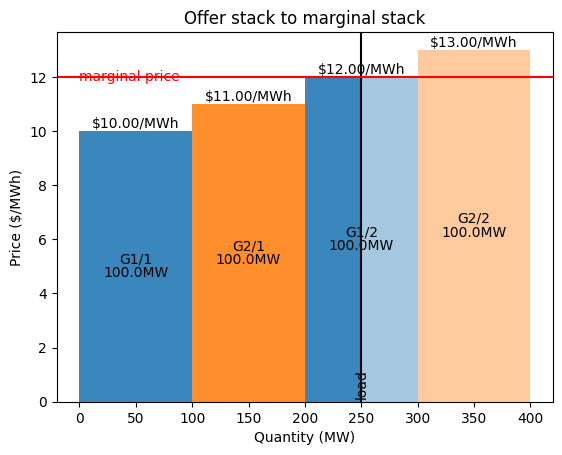

<Figure size 640x480 with 0 Axes>

In [64]:
plt.savefig("single_bus.png", dpi=300)
display(fig)